XOR

In [2]:
import numpy as np
import torch
import torch.utils.data as tud
import torch.nn as tnn

In [3]:
import matplotlib.pyplot as plt

In [4]:
class xor_dataset(tud.Dataset):
  def __init__(self, size=10000):
    # purposely getting dataset from np as random values might be different for torch
    np.random.seed(0)
    self.data = torch.from_numpy(2 * np.random.uniform(size=(size, 2)) - 1)
    # as suggested on teams, using two output nodes
    labels = torch.zeros((size, 1))
    labels[self.data[:, 0]*self.data[:, 1]<0, 0]=1
    self.labels=labels
  
  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return {'point': self.data[idx], 'label': self.labels[idx]}

In [5]:
train_set, val_set, test_set = tud.random_split(xor_dataset(), [7000,1500,1500], generator=torch.Generator().manual_seed(0))

In [6]:
train_loader = tud.DataLoader(train_set, batch_size=16, shuffle=True, drop_last=True)
val_loader = tud.DataLoader(val_set, batch_size=1500, shuffle=True, drop_last=True)
test_loader = tud.DataLoader(test_set, batch_size=1500, shuffle=True, drop_last=True)

In [7]:
class my_nn_1(tnn.Module):
  def __init__(self, h, d_in=2, d_out=1):
    super(my_nn_1, self).__init__()
    self.linear1 = tnn.Linear(d_in, h)
    self.linear2 = tnn.Linear(h, d_out)
    self.sig = tnn.Sigmoid() # since loss cant be calculated for ouputs exceeding 1

  def forward(self, x):
    h_relu = self.linear1(x).clamp(min=0)
    z_pred = self.linear2(h_relu)
    y_pred = self.sig(z_pred)
    return y_pred

In [8]:
# cross entropy loss isn't valid for binary classification
# hence binary cross entropy is used
crit_bce = tnn.BCELoss()
crit_mse = tnn.MSELoss()

In [9]:
from copy import deepcopy as dcopy

In [10]:
def fit(h=4, epochs=10, criterion=tnn.BCELoss(), lr=1e-3):
  model = my_nn_1(h)
  opt = torch.optim.SGD(model.parameters(), lr=lr)
  tlh=[]
  tah=[]
  vlh=[]
  vah=[]
  vl_min=10**10
  for ep in range(epochs):
    model.train()
    training_loss=0
    acc=0
    for (idx, b) in enumerate(train_loader):
      xb=b["point"].float()
      yb=b["label"]
      yb_pred = model(xb)
      loss=criterion(yb_pred, yb)
      training_loss+=loss
      acc+=torch.sum(torch.round(yb_pred)==yb)
      opt.zero_grad()
      loss.backward()
      opt.step()
    tah.append(acc/7000)
    tlh.append(training_loss/7000)
    model.eval()
    with torch.no_grad():
      val_loss=0
      acc=0
      for (idx, b) in enumerate(val_loader):
        xb=b["point"].float()
        yb=b["label"]
        yb_pred = model(xb)
        loss=criterion(yb_pred, yb)
        acc+=torch.sum(torch.round(yb_pred)==yb)
        val_loss+=loss
      vah.append(acc/1500)
      vl=val_loss/16
      if vl<vl_min:
        best_model=dcopy(model)
        vl_min=vl
      vlh.append(vl)
  return best_model, tlh, tah, vlh, vah

In [11]:
m, tlh, tah, vlh, vah = fit(epochs=100, criterion=crit_bce, lr=1e-3)

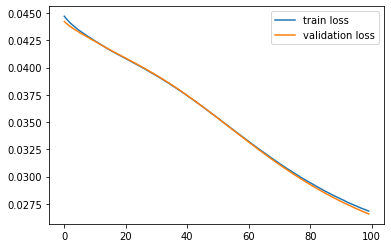

In [12]:
plt.plot(tlh, label="train loss")
plt.plot(vlh, label="validation loss")
plt.legend()
plt.show()

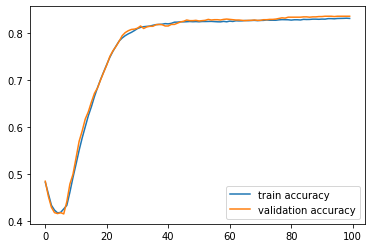

In [13]:
plt.plot(tah, label="train accuracy")
plt.plot(vah, label="validation accuracy")
plt.legend()
plt.show()

In [14]:
hl_sizes=[2,4,6,8,10]
best_vl=[]
for hl in hl_sizes:
  _, tlh, tah, vlh, vah = fit(h=hl, epochs=100, criterion=crit_bce, lr=1e-3)
  best_vl.append(np.min(vlh))

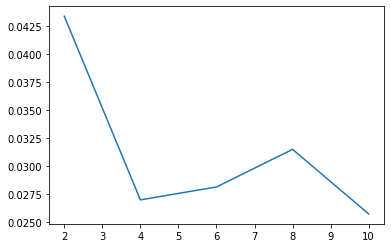

In [15]:
plt.plot(hl_sizes, best_vl)
plt.show()

In [16]:
# h=10 gives best results

In [17]:
lr_vals=[10**(i-5) for i in range(5)]
best_vl=[]
for lr in lr_vals:
  _, tlh, tah, vlh, vah = fit(epochs=20, criterion=crit_bce, lr=lr)
  best_vl.append(np.min(vlh))

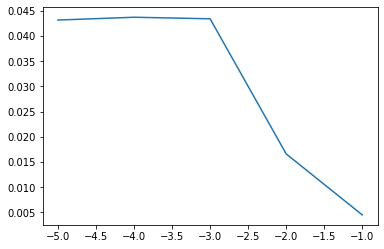

In [18]:
plt.plot(np.log10(lr_vals), best_vl)
plt.xlabel = "Learning rate as a power of 10"
plt.show()

In [19]:
# lr=0.1 gives best results

In [20]:
best_m, tlh, tah, vlh, vah = fit(h=4, epochs=100, criterion=crit_bce, lr=0.1)

In [21]:
full_test_loader = tud.DataLoader(test_set, batch_size=1500)
for pts in full_test_loader:
  test_pts=pts

In [23]:
# mean loss
label_pred = best_m(test_pts["point"].float())
crit_bce(label_pred, test_pts["label"])/16

tensor(0.0026, grad_fn=<DivBackward0>)

In [25]:
label_pred[label_pred<0.5]=0
label_pred[label_pred>=0.5]=1

In [26]:
# accuracy
print(torch.sum(label_pred==test_pts["label"])/(label_pred.shape[0]))

tensor(0.9853)


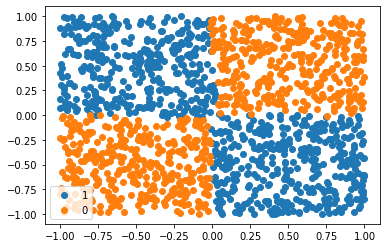

In [27]:
x=test_pts["point"][:, 0].reshape(-1,1)
y=test_pts["point"][:, 1].reshape(-1,1)
plt.scatter(x[label_pred==1], y[label_pred==1], label="1")
plt.scatter(x[label_pred==0], y[label_pred==0], label="0")
plt.legend()
plt.show()

In [28]:
# near perfect prediction

MNIST

In [29]:
import torchvision as tv
import torchvision.datasets as tvds

In [30]:
mnist_trainset = tvds.MNIST(root='./data', train=True, download=True, transform=tv.transforms.ToTensor())
mnist_testset = tvds.MNIST(root='./data', train=False, download=True, transform=tv.transforms.ToTensor())

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [31]:
train_set, val_set = tud.random_split(mnist_trainset, [50000,10000], generator=torch.Generator().manual_seed(0))

In [32]:
test_set=mnist_testset

In [33]:
del mnist_testset, mnist_trainset

In [34]:
# batch size increased for faster training
train_loader = tud.DataLoader(train_set, batch_size=64, shuffle=True, drop_last=True)
val_loader = tud.DataLoader(val_set, batch_size=10000, shuffle=True, drop_last=True)
test_loader = tud.DataLoader(test_set, batch_size=10000, shuffle=True, drop_last=True)

In [35]:
class my_nn_2(tnn.Module):
  def __init__(self, h=128, d_in=784, d_out=10):
    super(my_nn_2, self).__init__()
    self.linear1 = tnn.Linear(d_in, h)
    self.linear2 = tnn.Linear(h, d_out)
    # https://medium.com/@zhang_yang/understanding-cross-entropy-implementation-in-pytorch-softmax-log-softmax-nll-cross-entropy-416a2b200e34
    # softmax + nll loss is worse than cross entropy loss

  def forward(self, x):
    h_relu = self.linear1(x).clamp(min=0)
    y_pred = self.linear2(h_relu)
    return y_pred

In [36]:
crit_bce = tnn.CrossEntropyLoss()
crit_mse = tnn.MSELoss()

In [47]:
def fit(h=128, epochs=10, criterion=tnn.CrossEntropyLoss(), lr=1e-3):
  model = my_nn_2(h)
  opt = torch.optim.SGD(model.parameters(), lr=lr)
  tlh=[]
  tah=[]
  vlh=[]
  vah=[]
  vl_min=10**10
  for ep in range(epochs):
    model.train()
    training_loss=0
    acc=0
    for (idx, b) in enumerate(train_loader):
      xb=b[0].reshape(-1,784).float()
      yb=b[1]
      yb_pred = model(xb)
      loss=criterion(yb_pred, yb)
      training_loss+=loss
      acc+=torch.sum(torch.argmax(yb_pred, axis=1)==yb)
      opt.zero_grad()
      loss.backward()
      opt.step()
    tah.append(acc/50000)
    tlh.append(training_loss/50000)
    model.eval()
    with torch.no_grad():
      val_loss=0
      acc=0
      for (idx, b) in enumerate(val_loader):
        xb=b[0].reshape(-1,784).float()
        yb=b[1]
        yb_pred = model(xb)
        loss=criterion(yb_pred, yb)
        acc+=torch.sum(torch.argmax(yb_pred, axis=1)==yb)
        val_loss+=loss
      vah.append(acc/10000)
      vl=val_loss/64
      if vl<vl_min:
        best_model=dcopy(model)
        vl_min=vl
      vlh.append(vl)
  return best_model, tlh, tah, vlh, vah

In [48]:
model, tlh, tah, vlh, vah = fit()

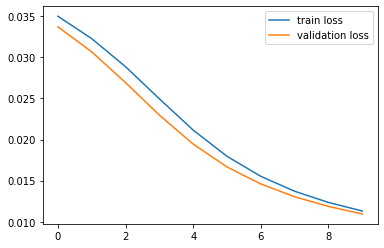

In [49]:
plt.plot(tlh, label="train loss")
plt.plot(vlh, label="validation loss")
plt.legend()
plt.show()

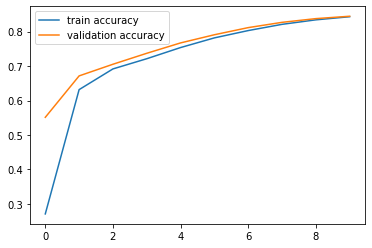

In [50]:
plt.plot(tah, label="train accuracy")
plt.plot(vah, label="validation accuracy")
plt.legend()
plt.show()

In [54]:
hl_sizes=[32,64,128,256,512]
best_vl=[]
for hl in hl_sizes:
  _, tlh, tah, vlh, vah = fit(h=hl, epochs=20, lr=1e-3)
  best_vl.append(np.min(vlh))

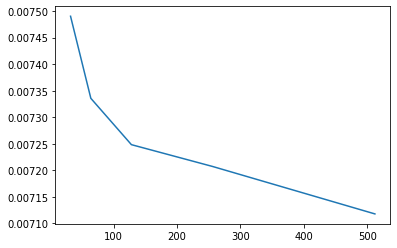

In [55]:
plt.plot(hl_sizes, best_vl)
plt.show()

In [56]:
# h=512 gives best results

In [57]:
lr_vals=[10**(i-5) for i in range(5)]
best_vl=[]
for lr in lr_vals:
  _, tlh, tah, vlh, vah = fit(epochs=20, lr=lr)
  best_vl.append(np.min(vlh))

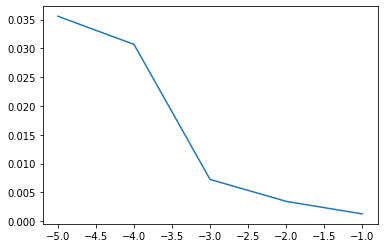

In [58]:
plt.plot(np.log10(lr_vals), best_vl)
plt.xlabel = "Learning rate as a power of 10"
plt.show()

In [59]:
# lr=0.1 gives best results